<a href="https://colab.research.google.com/github/IamManhChien/imageclassification/blob/main/tensorimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import platform
import psutil
import tensorflow as tf
print('OS:', platform.platform())
print('CPU:', platform.processor())
print('RAM:', round(psutil.virtual_memory().total / (1024**3), 2), 'GB')
print('GPU:', tf.config.list_physical_devices('GPU'))

OS: Linux-6.1.123+-x86_64-with-glibc2.35
CPU: x86_64
RAM: 12.67 GB
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from datasets import load_dataset

ds = load_dataset("Isamu136/big-animal-dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# subset = ds['train'].select(range(20000))
split = ds["train"].train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
test_ds = split["test"]

In [ ]:
X_train = train_ds['image']
y_train = train_ds['caption']  # hoặc 'label' tùy tên cột
X_test = test_ds['image']
y_test = test_ds['caption']

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [ ]:
import numpy as np

# Resize từng ảnh về (32, 32) và chuyển sang numpy array
X_train = np.array([np.array(img.resize((32, 32)).convert('RGB')).reshape(32, 32, 3) for img in X_train])
X_test = np.array([np.array(img.resize((32, 32)).convert('RGB')).reshape(32, 32, 3) for img in X_test])

In [ ]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
mean = np.mean(X_train)
std  = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_int = le.fit_transform(y_train)  # Chuyển thành số nguyên
y_train_cat = to_categorical(y_train_int, num_classes=len(le.classes_))  # One-hot nếu cần

y_test_int = le.transform(y_test)  # Chuyển thành số nguyên
y_test_cat = to_categorical(y_test_int, num_classes=len(le.classes_))  # One-hot nếu cần

In [ ]:
num_classes = len(le.classes_)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def resnet_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, (3,3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ImageDefineModel(input_shape=(32,32,3), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3,3), strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 2 blocks of 64 filters
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    # 2 blocks of 128 filters
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)

    # 2 blocks of 256 filters
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)

    # 2 blocks of 512 filters
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = ImageDefineModel(input_shape=(32,32,3), num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 11,262,051 (42.96 MB)

 Trainable params: 11,252,451 (42.92 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9,1.1],
    shear_range=10,
    channel_shift_range=0.1,
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1)

start_time = time.time()

history = model.fit(
    data_generator.flow(X_train, y_train_cat, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test_cat),
    callbacks=[checkpoint, reduce_lr, early_stop]
)

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time/60:.2f} minutes")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1830 - loss: 4.0112

777/777 ━━━━━━━━━━━━━━━━━━━━ 105s 108ms/step - accuracy: 0.1830 - loss: 4.0109 - val_accuracy: 0.2282 - val_loss: 3.7701 - learning_rate: 0.0010
Epoch 2/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2868 - loss: 3.3519

777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.2868 - loss: 3.3518 - val_accuracy: 0.3018 - val_loss: 3.1933 - learning_rate: 0.0010
Epoch 3/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3287 - loss: 3.0385

777/777 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.3287 - loss: 3.0384 - val_accuracy: 0.3455 - val_loss: 2.9744 - learning_rate: 0.0010
Epoch 4/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3721 - loss: 2.7586

777/777 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - accuracy: 0.3721 - loss: 2.7586 - val_accuracy: 0.3814 - val_loss: 2.7219 - learning_rate: 0.0010
Epoch 5/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3979 - loss: 2.5440

777/777 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.3979 - loss: 2.5440 - val_accuracy: 0.3775 - val_loss: 2.6618 - learning_rate: 0.0010
Epoch 6/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.4298 - loss: 2.3361 - val_accuracy: 0.3169 - val_loss: 3.1846 - learning_rate: 0.0010
Epoch 7/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.4544 - loss: 2.1978 - val_accuracy: 0.3795 - val_loss: 2.7171 - learning_rate: 0.0010
Epoch 8/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4802 - loss: 2.0521
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
777/777 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.4802 - loss: 2.0521 - val_accuracy: 0.3564 - val_loss: 2.9017 - learning_rate: 0.0010
Epoch 9/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5262 - loss: 1.8226

777/777 ━━━━━━━━━━━━━━━━━━━━ 72s 93ms/step - accuracy: 0.5262 - loss: 1.8226 - val_accuracy: 0.4921 - val_loss: 2.0564 - learning_rate: 5.0000e-04
Epoch 10/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 79s 89ms/step - accuracy: 0.5517 - loss: 1.6864 - val_accuracy: 0.4693 - val_loss: 2.1546 - learning_rate: 5.0000e-04
Epoch 11/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.5706 - loss: 1.6062 - val_accuracy: 0.4896 - val_loss: 2.0625 - learning_rate: 5.0000e-04
Epoch 12/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5796 - loss: 1.5168

777/777 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.5796 - loss: 1.5168 - val_accuracy: 0.5019 - val_loss: 2.0234 - learning_rate: 5.0000e-04
Epoch 13/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.5983 - loss: 1.4614 - val_accuracy: 0.4517 - val_loss: 2.3979 - learning_rate: 5.0000e-04
Epoch 14/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.6109 - loss: 1.3985 - val_accuracy: 0.4788 - val_loss: 2.1581 - learning_rate: 5.0000e-04
Epoch 15/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6258 - loss: 1.3322
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.6258 - loss: 1.3322 - val_accuracy: 0.5033 - val_loss: 2.1102 - learning_rate: 5.0000e-04
Epoch 16/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6612 - loss: 1.1818

777/777 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.6612 - loss: 1.1818 - val_accuracy: 0.5263 - val_loss: 1.9694 - learning_rate: 2.5000e-04
Epoch 17/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.6790 - loss: 1.1118 - val_accuracy: 0.5174 - val_loss: 2.0213 - learning_rate: 2.5000e-04
Epoch 18/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.6926 - loss: 1.0542 - val_accuracy: 0.5246 - val_loss: 2.0194 - learning_rate: 2.5000e-04
Epoch 19/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7031 - loss: 1.0166
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
777/777 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.7031 - loss: 1.0166 - val_accuracy: 0.5070 - val_loss: 2.1349 - learning_rate: 2.5000e-04
Epoch 20/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7309 - loss: 0.9181

777/777 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.7309 - loss: 0.9181 - val_accuracy: 0.5356 - val_loss: 1.9417 - learning_rate: 1.2500e-04
Epoch 21/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.7392 - loss: 0.8853 - val_accuracy: 0.5250 - val_loss: 2.0482 - learning_rate: 1.2500e-04
Epoch 22/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7513 - loss: 0.8480

777/777 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7513 - loss: 0.8480 - val_accuracy: 0.5460 - val_loss: 1.9381 - learning_rate: 1.2500e-04
Epoch 23/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.7611 - loss: 0.8094 - val_accuracy: 0.5208 - val_loss: 2.1113 - learning_rate: 1.2500e-04
Epoch 24/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7653 - loss: 0.7856

777/777 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7653 - loss: 0.7856 - val_accuracy: 0.5541 - val_loss: 1.9250 - learning_rate: 1.2500e-04
Epoch 25/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.7752 - loss: 0.7616 - val_accuracy: 0.5352 - val_loss: 2.0188 - learning_rate: 1.2500e-04
Epoch 26/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.7792 - loss: 0.7434 - val_accuracy: 0.5464 - val_loss: 1.9694 - learning_rate: 1.2500e-04
Epoch 27/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7843 - loss: 0.7183
Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
777/777 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7843 - loss: 0.7183 - val_accuracy: 0.5292 - val_loss: 2.1076 - learning_rate: 1.2500e-04
Epoch 28/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.8016 - loss: 0.6615 - val_accuracy: 0.5420 - val_loss: 2.0491 - learning_rate: 6.2500e-05
Epoch 29/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy

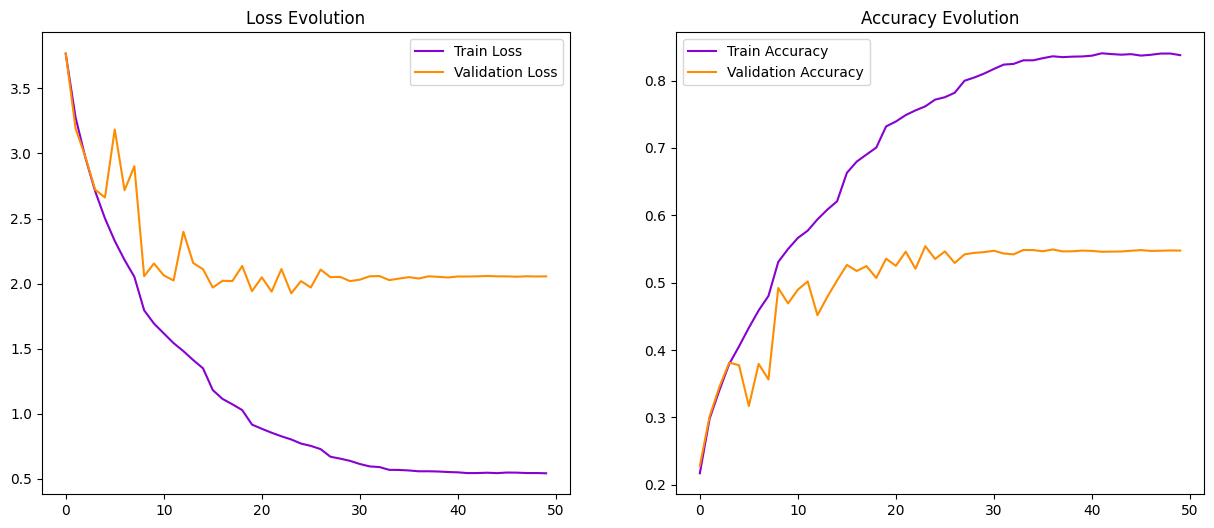

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

389/389 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


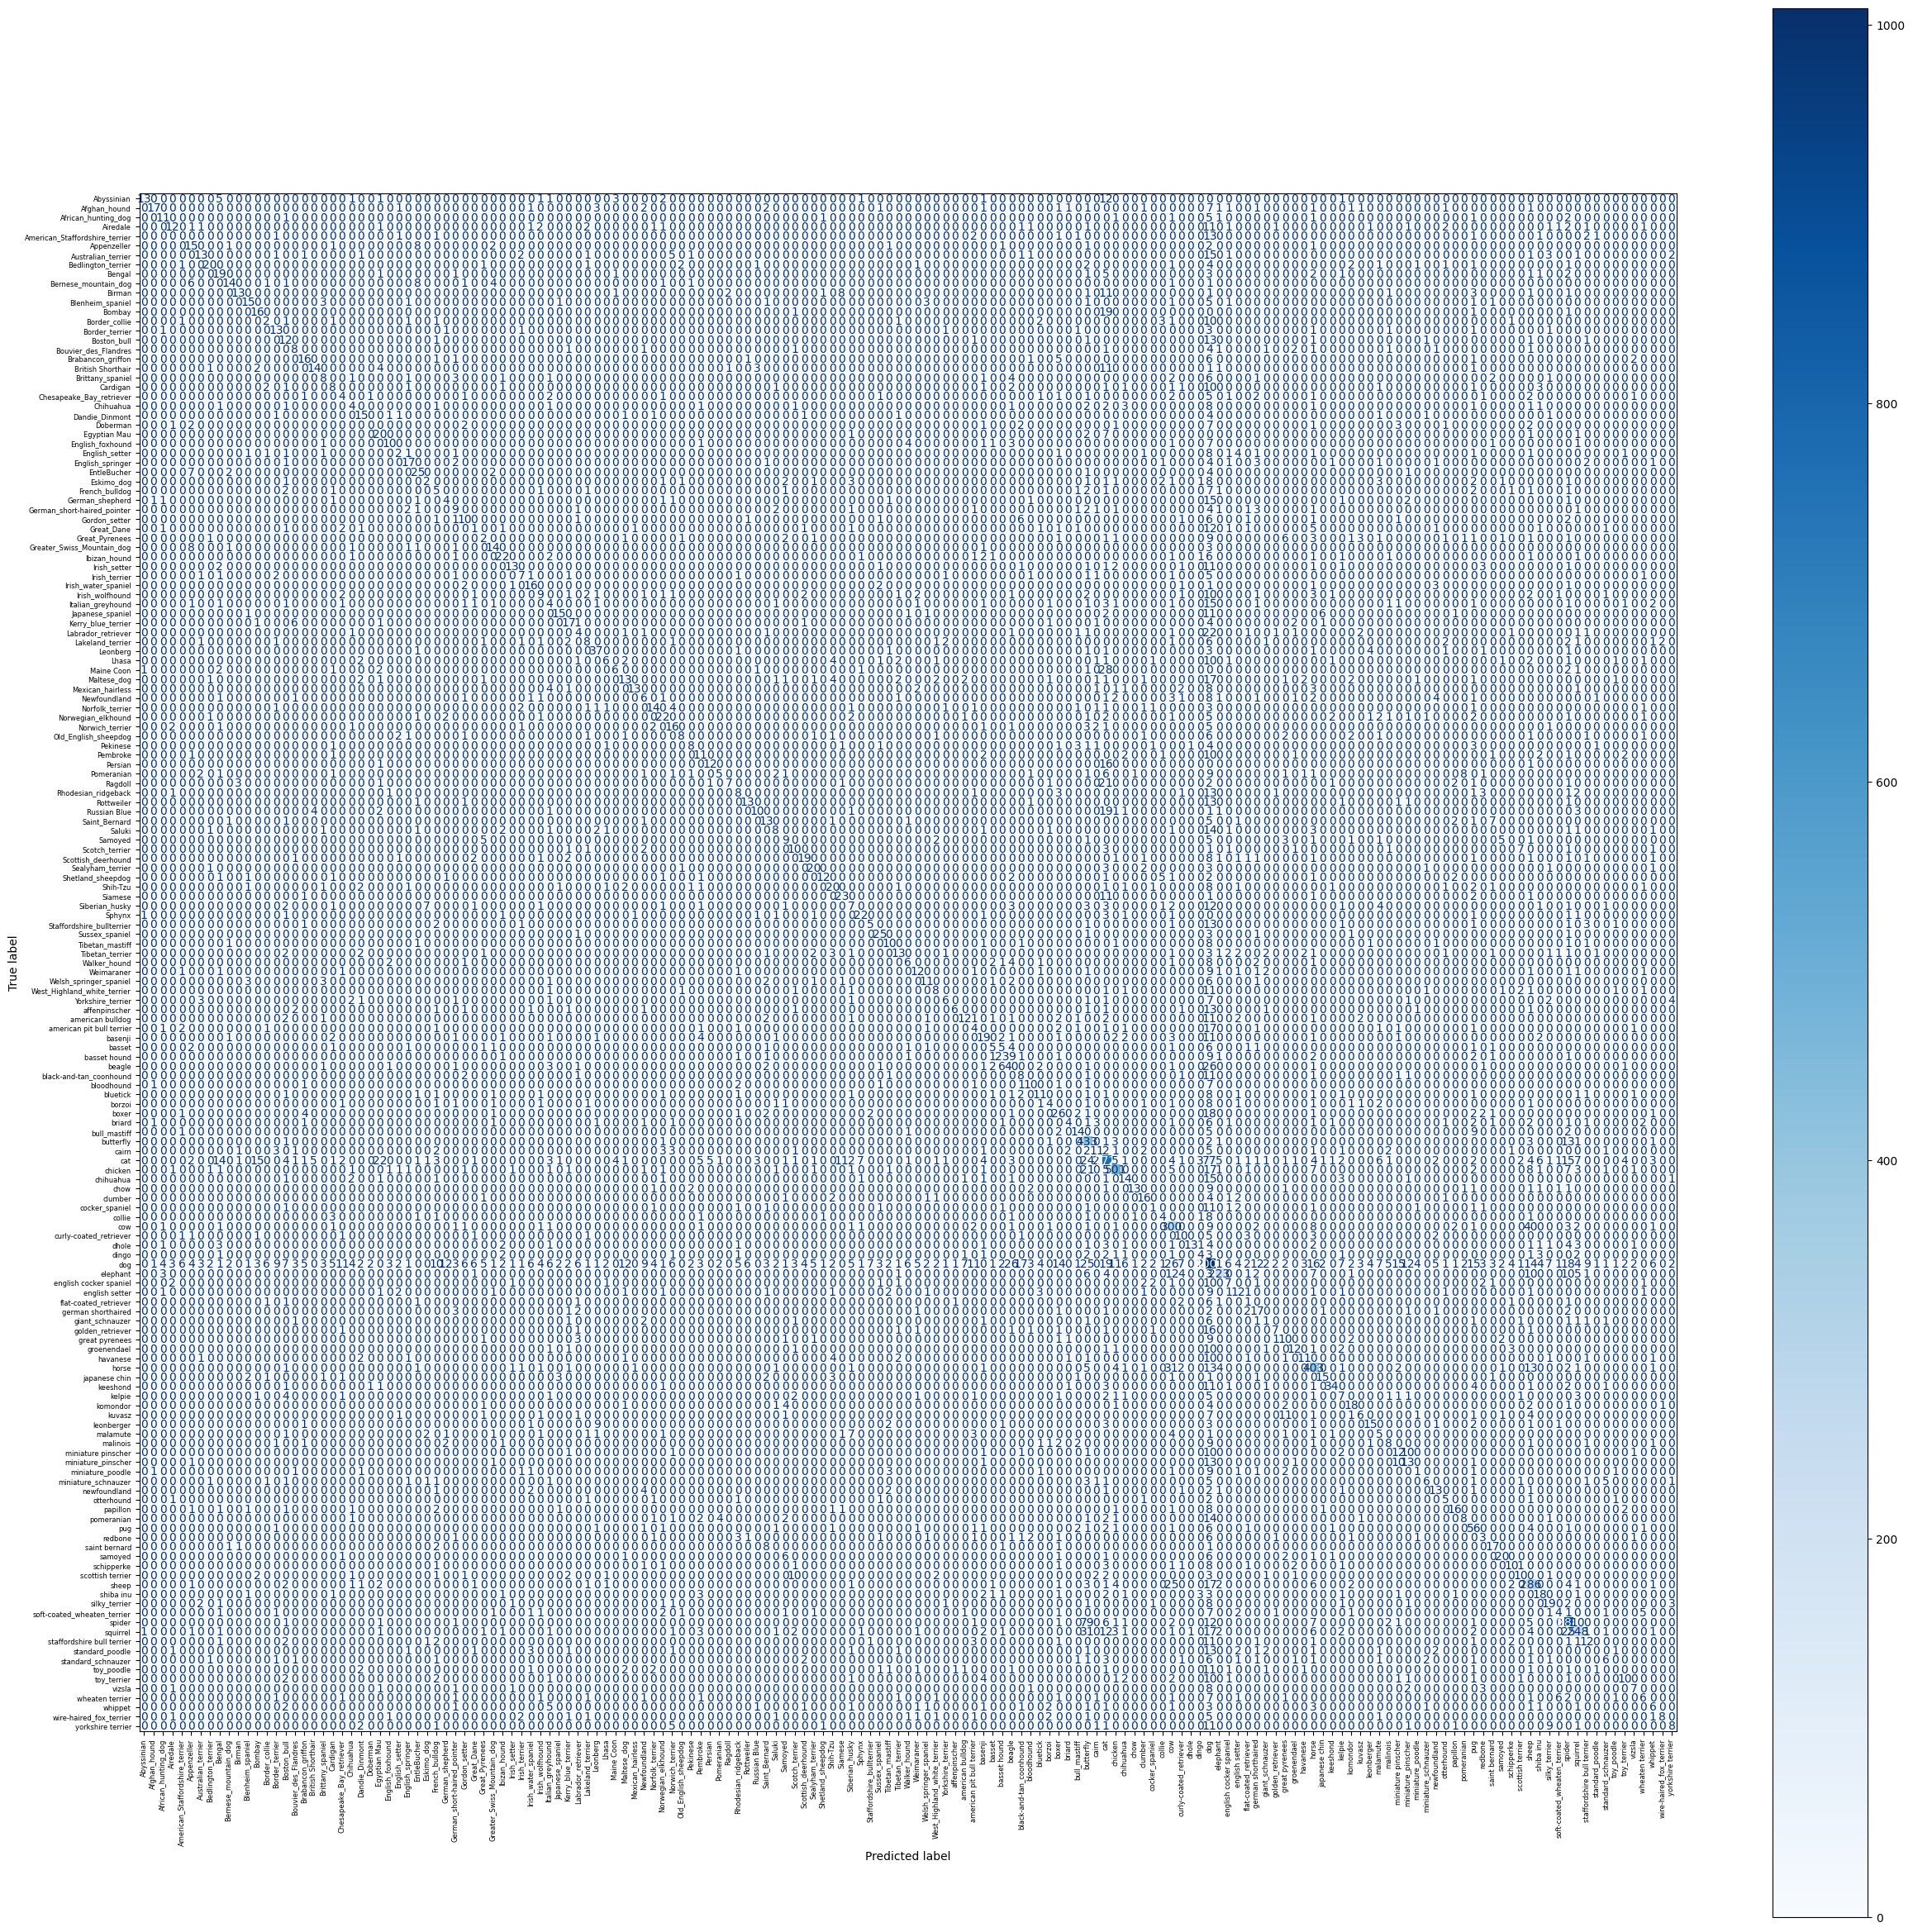

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Dự đoán trên tập test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(30, 30))  # chỉnh size tuỳ ý
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90, values_format='d')

# Tăng font size cho ticks
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_model(model, X, y_cat, label_encoder):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_cat, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

# Đánh giá trên tập test
evaluate_model(model, X_test, y_test_cat, le)

389/389 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Accuracy: 0.5476
Precision: 0.5488
Recall: 0.5476
F1-score: 0.5357
